In [3]:
!nvidia-smi

Wed Aug 27 16:53:17 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:01:00.0  On |                  Off |
| 30%   33C    P8              17W / 230W |     61MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os
import numpy as np
import cv2
import random
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics import F1Score, Precision, Recall
import wandb

/media/HDD/fdittaro/env/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
wandb.login()

wandb: Currently logged in as: federico-dittaro (federico-dittaro-university-of-udine) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(
    project="Fourth_phase_CropAndWeed_dataset-segmentation", 
    name=f"run_CropAndWeed_seg_standard_DiceLoss",
    config={
        "epochs": 50,
        "batch_size": 32
    }
)

In [2]:
"""Divisione del dataset in 70% training, 15% validation e 15% test"""
images_dir = "../../cropandweed-dataset/images"

all_ids = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
total = len(all_ids)

random.seed(42)
random.shuffle(all_ids)

train_size = int(total * 0.70)
val_size = int(total * 0.15)
test_size = total - train_size - val_size

train_ids = all_ids[:train_size]
val_ids = all_ids[train_size:train_size + val_size]
test_ids = all_ids[train_size + val_size:]

print(f"Training set: {len(train_ids)} immagini")
print(f"Validation set: {len(val_ids)} immagini")
print(f"Test set: {len(test_ids)} immagini")

Training set: 5623 immagini
Validation set: 1205 immagini
Test set: 1206 immagini


In [3]:
class CropAndWeedDataset(Dataset):
    """
    image_ids: lista degli ID immagine
    images_dir: cartella dove si trovano le immagini
    masks_dir: cartella dove si trovano le maschere corrispondenti
    transform: trasformazioni da applicare
    """
    def __init__(self, image_ids, images_dir, masks_dir, transform=None):
        self.image_ids = image_ids 
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
    """ Restituisce la lunghezza del dataset (necessario per PyTorch DataLoader)."""
    def __len__(self):
        return len(self.image_ids)
    
    """Dato un indice recupera la coppia (immagine, maschera), applica trasformazioni coerenti ad entrambi
    e le converte in tensori Pytorch. La label con id 255 viene rimappata come 100."""
    def __getitem__(self, idx):
        img_filename = self.image_ids[idx]
        img_path = os.path.join(self.images_dir, img_filename)

        mask_filename = os.path.splitext(img_filename)[0] + ".png"
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(np.array(image) / 255.0, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        mask[mask == 255] = 100

        return image, mask

train_transform = A.Compose([A.Resize(256, 256)])
val_transform = A.Compose([A.Resize(256, 256)])
test_transform = A.Compose([A.Resize(256, 256)])

train_loader = DataLoader(
    CropAndWeedDataset(train_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=train_transform),
    batch_size=32, shuffle=True
)

val_loader = DataLoader(
    CropAndWeedDataset(val_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=val_transform),
    batch_size=32, shuffle=False
)

test_loader = DataLoader(
    CropAndWeedDataset(test_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=test_transform),
    batch_size=32, shuffle=False
)

In [4]:
"""Costruzione del modello UNet con EfficientNetB0 come backbone. Il modello carica pesi pre-addestrati su ImageNet
per l'encoder. Le immagini in input hanno tre canali (RGB) e 101 classi di output (una per ciascuna classe di
segmentazione)"""

model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=101
)

In [3]:
# CONTEGGIO PIXEL PER LA WEIGHTED CROSS ENTROPY LOSS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask_dir = "../../cropandweed-dataset/labelIds/CropAndWeed"

num_classes = 101
class_counts = np.zeros(num_classes, dtype=np.int64)
found_classes = set()

# Conta i pixel per classe e registra le classi uniche trovate
for img_id in tqdm(all_ids, desc="Conteggio pixel per classe"):
    mask_filename = os.path.splitext(img_id)[0] + ".png"
    mask_path = os.path.join(mask_dir, mask_filename)
    mask = np.array(Image.open(mask_path).resize((256, 256), resample=Image.NEAREST))

    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        if u < num_classes:
            class_counts[u] += c
            found_classes.add(int(u))  

# Mostra le classi trovate e i conteggi
print("\n✅ Classi uniche trovate nel training set:", sorted(found_classes))
print("📊 Pixel per classe:")
for i in range(num_classes):
    print(f"Classe {i:2d}: {class_counts[i]:>10}")

"""
# Calcolo dei pesi: logaritmo del bilanciamento inverso
epsilon = 1e-6
total_pixels = class_counts.sum()
inv_freq = total_pixels / (class_counts + epsilon)
class_weights = np.log(1.0 + inv_freq)

# Converti in tensore PyTorch
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# (Opzionale) stampa dei pesi
print("\n⚖️ Pesi calcolati per CrossEntropyLoss (log balanced):")
for i, w in enumerate(class_weights):
    print(f"Classe {i:2d}: Peso = {w:.6f}")
"""

Conteggio pixel per classe: 100%|██████████████████████████████████████████████████| 8034/8034 [00:42<00:00, 189.26it/s]


✅ Classi uniche trovate nel training set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 99]
📊 Pixel per classe:
Classe  0:  509262095
Classe  1:    1523454
Classe  2:     156776
Classe  3:     307956
Classe  4:     250159
Classe  5:      72917
Classe  6:      40696
Classe  7:     740987
Classe  8:      57780
Classe  9:     275047
Classe 10:    1101707
Classe 11:     756270
Classe 12:     256472
Classe 13:      83853
Classe 14:      17979
Classe 15:     520252
Classe 16:          0
Classe 17:          0
Classe 18:     370505
Classe 19:      74502
Classe 20:     120261
Classe 21:     205919
Classe 22:      10231
Classe 23:          0
Classe 24:     875663
Classe 25:       3594
Classe 26:      44848
Classe 27:  

'\n# Calcolo dei pesi: logaritmo del bilanciamento inverso\nepsilon = 1e-6\ntotal_pixels = class_counts.sum()\ninv_freq = total_pixels / (class_counts + epsilon)\nclass_weights = np.log(1.0 + inv_freq)\n\n# Converti in tensore PyTorch\nweights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)\n\n# (Opzionale) stampa dei pesi\nprint("\n⚖️ Pesi calcolati per CrossEntropyLoss (log balanced):")\nfor i, w in enumerate(class_weights):\n    print(f"Classe {i:2d}: Peso = {w:.6f}")\n'

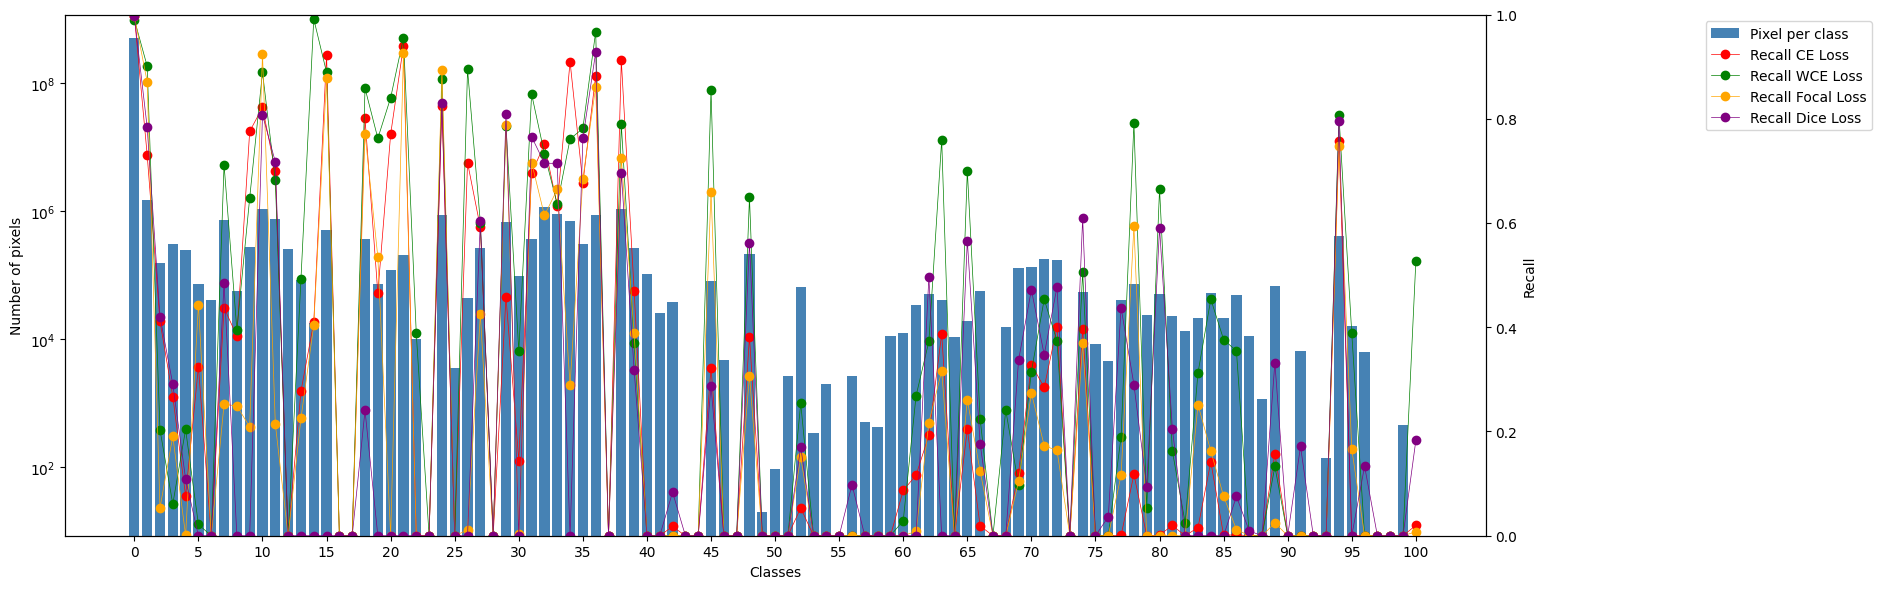

In [12]:
# GRAFICO RECALL PER LE DIVERSE FUNZIONI DI PERDITA
classes = np.arange(num_classes)

# 4 array di recall
recall_CE = np.array([0.9978, 0.7310, 0.4112, 0.2671, 0.0766, 0.3241, 0, 0.4374, 0.3832, 0.7756, 0.8218, 0.6992, 
                      0.0000, 0.2770, 0.4095, 0.9228, 0, 0, 0.8005, 0.4652, 0.7702, 0.9400, 0.0000, 0, 0.8246, 0, 
                      0.7159, 0.5914, 0, 0.4581, 0.1443, 0.6954, 0.7510, 0.6335, 0.9095, 0.6759, 0.8829, 0, 0.9121, 
                      0.4699, 0.0000, 0, 0.0177, 0, 0, 0.3227, 0, 0, 0.3817, 0, 0, 0, 0.0533, 0, 0, 0, 0.0000, 0, 0, 
                      0.0000, 0.0869, 0.1162, 0.1929, 0.3873, 0.0000, 0.2045, 0.0188, 0, 0.0000, 0.1210, 0.3282, 
                      0.2847, 0.4008, 0, 0.3975, 0, 0.0000, 0.0006, 0.1176, 0.0000, 0.0013, 0.0197, 0.0000, 0.0156, 
                      0.1419, 0.0008, 0.0018, 0.0000, 0, 0.1575, 0, 0.0000, 0, 0, 0.7579, 0.0000, 0.0000, 0, 0, 0, 
                      0.0200])

recall_WCE = np.array([0.9904, 0.9010, 0.2034, 0.0608, 0.2039, 0.0216, 0, 0.7120, 0.3947, 0.6478, 0.8892, 0.6820, 
                       0.0000, 0.4921, 0.9914, 0.8890, 0, 0, 0.8586, 0.7625, 0.8403, 0.9554, 0.3880, 0, 0.8755, 0, 
                       0.8947, 0.6006, 0, 0.7861, 0.3545, 0.8473, 0.7331, 0.6361, 0.7611, 0.7814, 0.9672, 0, 0.7890, 
                       0.3704, 0.0000, 0, 0.0000, 0, 0, 0.8556, 0, 0, 0.6491, 0, 0, 0, 0.2537, 0, 0, 0, 0.0000, 0, 0, 
                       0.0000, 0.0290, 0.2684, 0.3729, 0.7597, 0.0000, 0.7002, 0.2244, 0, 0.2409, 0.0969, 0.3150, 
                       0.4537, 0.3734, 0, 0.5051, 0, 0.0000, 0.1901, 0.7919, 0.0528, 0.6654, 0.1623, 0.0249, 0.3125, 
                       0.4538, 0.3764, 0.3544, 0.0000, 0, 0.1329, 0, 0.0000, 0, 0, 0.8063, 0.3884, 0.0000, 0, 0, 0, 
                       0.5265])

recall_FOCAL = np.array([0.9970, 0.8711, 0.0533, 0.1911, 0.0007, 0.4433, 0, 0.2522, 0.2490, 0.2090, 0.9244, 0.2146, 
                         0.0000, 0.2250, 0.4040, 0.8790, 0, 0, 0.7713, 0.5346, 0.0000, 0.9263, 0.0000, 0, 0.8942, 0, 
                         0.0109, 0.4249, 0, 0.7886, 0.0038, 0.7158, 0.6145, 0.6643, 0.2889, 0.6848, 0.8615, 0, 0.7245, 
                         0.3880, 0.0000, 0, 0.0000, 0, 0, 0.6601, 0, 0, 0.3072, 0, 0, 0, 0.1501, 0, 0, 0, 0.0000, 0, 
                         0, 0.0000, 0.0000, 0.0084, 0.2172, 0.3164, 0.0000, 0.2606, 0.1238, 0, 0.0000, 0.1041, 0.2737, 
                         0.1727, 0.1636, 0, 0.3697, 0, 0.0000, 0.1164, 0.5939, 0.0000, 0.0001, 0.0002, 0.0000, 0.2513, 
                         0.1627, 0.0756, 0.0119, 0.0000, 0, 0.0246, 0, 0.0000, 0, 0, 0.7474, 0.1660, 0.0000, 0, 0, 0, 
                         0.0076])

recall_DICE = np.array([0.9963, 0.7837, 0.4204, 0.2907, 0.1088, 0.0000, 0, 0.4848, 0.0000, 0.0000, 0.8079, 0.7173, 
                        0.0000, 0.0000, 0.0000, 0.0000, 0, 0, 0.2404, 0.0000, 0.0000, 0.0000, 0.0000, 0, 0.8309, 0, 
                        0.0000, 0.6034, 0, 0.8091, 0.0000, 0.7655, 0.7147, 0.7143, 0.0000, 0.7623, 0.9276, 0, 0.6968, 
                        0.3175, 0.0000, 0, 0.0836, 0, 0, 0.2864, 0, 0, 0.5625, 0, 0, 0, 0.1705, 0, 0, 0, 0.0979, 0, 0, 
                        0.0000, 0.0000, 0.0000, 0.4964, 0.0000, 0.0000, 0.5663, 0.1765, 0, 0.0000, 0.3369, 0.4720, 
                        0.3472, 0.4776, 0, 0.6090, 0, 0.0363, 0.4373, 0.2900, 0.0940, 0.5906, 0.2049, 0.0000, 0.0000, 
                        0.0000, 0.0000, 0.0754, 0.0092, 0, 0.3319, 0, 0.1713, 0, 0, 0.7961, 0.0000, 0.1334, 0, 0, 0,
                        0.1829])

fig, ax1 = plt.subplots(figsize=(19, 6))

# --- Barre pixel (asse Y sinistro) ---
ax1.bar(classes, class_counts, color='steelblue', label="Pixel per class")
ax1.set_yscale('log')
ax1.set_ylabel("Number of pixels")

# --- Linee recall (asse Y destro) ---
ax2 = ax1.twinx()
ax2.plot(classes, recall_CE, color='red', marker='o', linewidth=0.5, label="Recall CE Loss")
ax2.plot(classes, recall_WCE, color='green', marker='o', linewidth=0.5, label="Recall WCE Loss")
ax2.plot(classes, recall_FOCAL, color='orange', marker='o', linewidth=0.5, label="Recall Focal Loss")
ax2.plot(classes, recall_DICE, color='purple', marker='o', linewidth=0.5, label="Recall Dice Loss")
ax2.set_ylabel("Recall")
ax2.set_ylim(0, 1)

ax1.set_xlabel("Classes")
ax1.set_xticks(np.arange(0, num_classes, 5))

# --- Legenda combinata (barre + linee) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2,
           loc="upper left",             # posizione di riferimento
           bbox_to_anchor=(1.15, 1))    # sposta fuori a destra

plt.tight_layout()
plt.savefig("CaW_Recall_Losses.png", dpi=300)
plt.show()

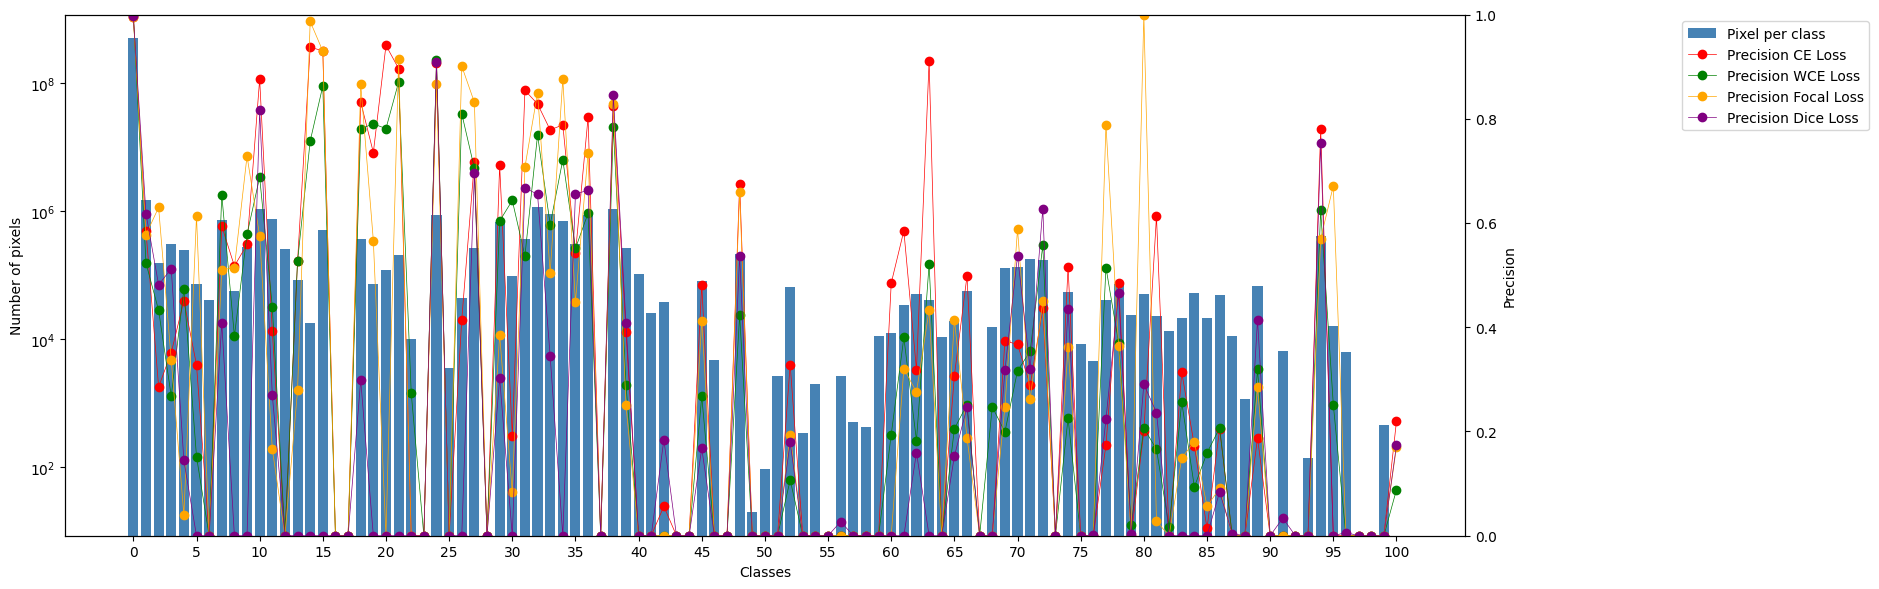

In [13]:
# GRAFICO PRECISION PER LE DIVERSE FUNZIONI DI PERDITA
classes = np.arange(num_classes)

# 4 array di precision
precision_CE = np.array([0.9958, 0.5841, 0.2856, 0.3512, 0.4509, 0.3279, 0, 0.5939, 0.5174, 0.5588, 0.8760, 0.3935, 
                         0.0000, 0.5263, 0.9372, 0.9303, 0, 0, 0.8320, 0.7352, 0.9408, 0.8963, 0.0000, 0, 0.9074, 0, 
                         0.4147, 0.7172, 0, 0.7107, 0.1921, 0.8544, 0.8284, 0.7786, 0.7882, 0.5417, 0.8027, 0, 0.8249,
                         0.3917, 0.0000, 0, 0.0565, 0, 0, 0.4818, 0, 0, 0.6755, 0, 0, 0, 0.3282, 0, 0, 0, 0.0000, 0, 0,
                         0.0000, 0.4846, 0.5851, 0.3185, 0.9113, 0.0000, 0.3071, 0.4983, 0, 0.0000, 0.3737, 0.3672, 
                         0.2889, 0.4364, 0, 0.5161, 0, 0.0000, 0.1739, 0.4841, 0.0000, 0.2000, 0.6131, 0.0000, 0.3136, 
                         0.1729, 0.0139, 0.2045, 0.0000, 0, 0.1877, 0, 0.0000, 0, 0, 0.7804, 0.0000, 0.0000, 0, 0, 0, 
                         0.2196])

precision_WCE = np.array([0.9989, 0.5231, 0.4325, 0.2680, 0.4732, 0.1519, 0, 0.6542, 0.3830, 0.5781, 0.6880, 0.4396, 
                          0.0000, 0.5269, 0.7572, 0.8629, 0, 0, 0.7809, 0.7901, 0.7812, 0.8703, 0.2735, 0, 0.9129, 0, 
                          0.8097, 0.7048, 0, 0.6038, 0.6433, 0.5367, 0.7689, 0.5969, 0.7214, 0.5511, 0.6187, 0, 0.7850,
                          0.2894, 0.0000, 0, 0.0000, 0, 0, 0.2673, 0, 0, 0.4232, 0, 0, 0, 0.1069, 0, 0, 0, 0.0000, 0, 
                          0, 0.0000, 0.1940, 0.3804, 0.1825, 0.5215, 0.0000, 0.2052, 0.2516, 0, 0.2472, 0.1991, 0.3165,
                          0.3539, 0.5573, 0, 0.2254, 0, 0.0000, 0.5146, 0.3707, 0.0201, 0.2064, 0.1659, 0.0166, 0.2565,
                          0.0936, 0.1588, 0.2068, 0.0000, 0, 0.3190, 0, 0.0000, 0, 0, 0.6240, 0.2515, 0.0000, 0, 0, 0, 
                          0.0882])

precision_FOCAL = np.array([0.9952, 0.5776, 0.6298, 0.3375, 0.0395, 0.6137, 0, 0.5101, 0.5145, 0.7285, 0.5753, 0.1666, 
                            0.0000, 0.2788, 0.9866, 0.9297, 0, 0, 0.8663, 0.5664, 0.0000, 0.9143, 0.0000, 0, 0.8664, 0,
                            0.9009, 0.8316, 0, 0.3847, 0.0830, 0.7071, 0.8499, 0.5044, 0.8765, 0.4483, 0.7341, 0, 
                            0.8275, 0.2500, 0.0000, 0, 0.0000, 0, 0, 0.4128, 0, 0, 0.6590, 0, 0, 0, 0.1927, 0, 0, 0, 
                            0.0000, 0, 0, 0.0000, 0.0000, 0.3202, 0.2758, 0.4328, 0.0000, 0.4147, 0.1880, 0, 0.0000, 
                            0.2476, 0.5883, 0.2619, 0.4506, 0, 0.3621, 0, 0.0000, 0.7888, 0.3646, 0.0000, 1.0000, 
                            0.0278, 0.0000, 0.1494, 0.1803, 0.0564, 0.0908, 0.0000, 0, 0.2845, 0, 0.0000, 0, 0, 0.5698,
                            0.6713, 0.0000, 0, 0, 0, 0.1693])

precision_DICE = np.array([0.9962, 0.6177, 0.4814, 0.5123, 0.1445, 0.0000, 0, 0.4084, 0.0000, 0.0000, 0.8169, 0.2699, 
                           0.0000, 0.0000, 0.0000, 0.0000, 0, 0, 0.2986, 0.0000, 0.0000, 0.0000, 0.0000, 0, 0.9090, 0, 
                           0.0000, 0.6968, 0, 0.3023, 0.0000, 0.6678, 0.6547, 0.3441, 0.0000, 0.6558, 0.6627, 0, 
                           0.8450, 0.4076, 0.0000, 0, 0.1843, 0, 0, 0.1678, 0, 0, 0.5358, 0, 0, 0, 0.1794, 0, 0, 0, 
                           0.0271, 0, 0, 0.0000, 0.0000, 0.0000, 0.1596, 0.0000, 0.0000, 0.1527, 0.2468, 0, 0.0000, 
                           0.3170, 0.5371, 0.3208, 0.6275, 0, 0.4357, 0, 0.0009, 0.2232, 0.4649, 0.0024, 0.2905, 0.2363,
                           0.0000, 0.0000, 0.0000, 0.0000, 0.0840, 0.0039, 0, 0.4145, 0, 0.0337, 0, 0, 0.7533, 0.0000, 
                           0.0061, 0, 0, 0, 0.1736])

fig, ax1 = plt.subplots(figsize=(19, 6))

# --- Barre pixel (asse Y sinistro) ---
ax1.bar(classes, class_counts, color='steelblue', label="Pixel per class")
ax1.set_yscale('log')
ax1.set_ylabel("Number of pixels")

# --- Linee recall (asse Y destro) ---
ax2 = ax1.twinx()
ax2.plot(classes, precision_CE, color='red', marker='o', linewidth=0.5, label="Precision CE Loss")
ax2.plot(classes, precision_WCE, color='green', marker='o', linewidth=0.5, label="Precision WCE Loss")
ax2.plot(classes, precision_FOCAL, color='orange', marker='o', linewidth=0.5, label="Precision Focal Loss")
ax2.plot(classes, precision_DICE, color='purple', marker='o', linewidth=0.5, label="Precision Dice Loss")
ax2.set_ylabel("Precision")
ax2.set_ylim(0, 1)

ax1.set_xlabel("Classes")
ax1.set_xticks(np.arange(0, num_classes, 5))

# --- Legenda combinata (barre + linee) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2,
           loc="upper left",             # posizione di riferimento
           bbox_to_anchor=(1.15, 1))    # sposta fuori a destra

plt.tight_layout()
plt.savefig("CaW_Precision_Losses.png", dpi=300)
plt.show()

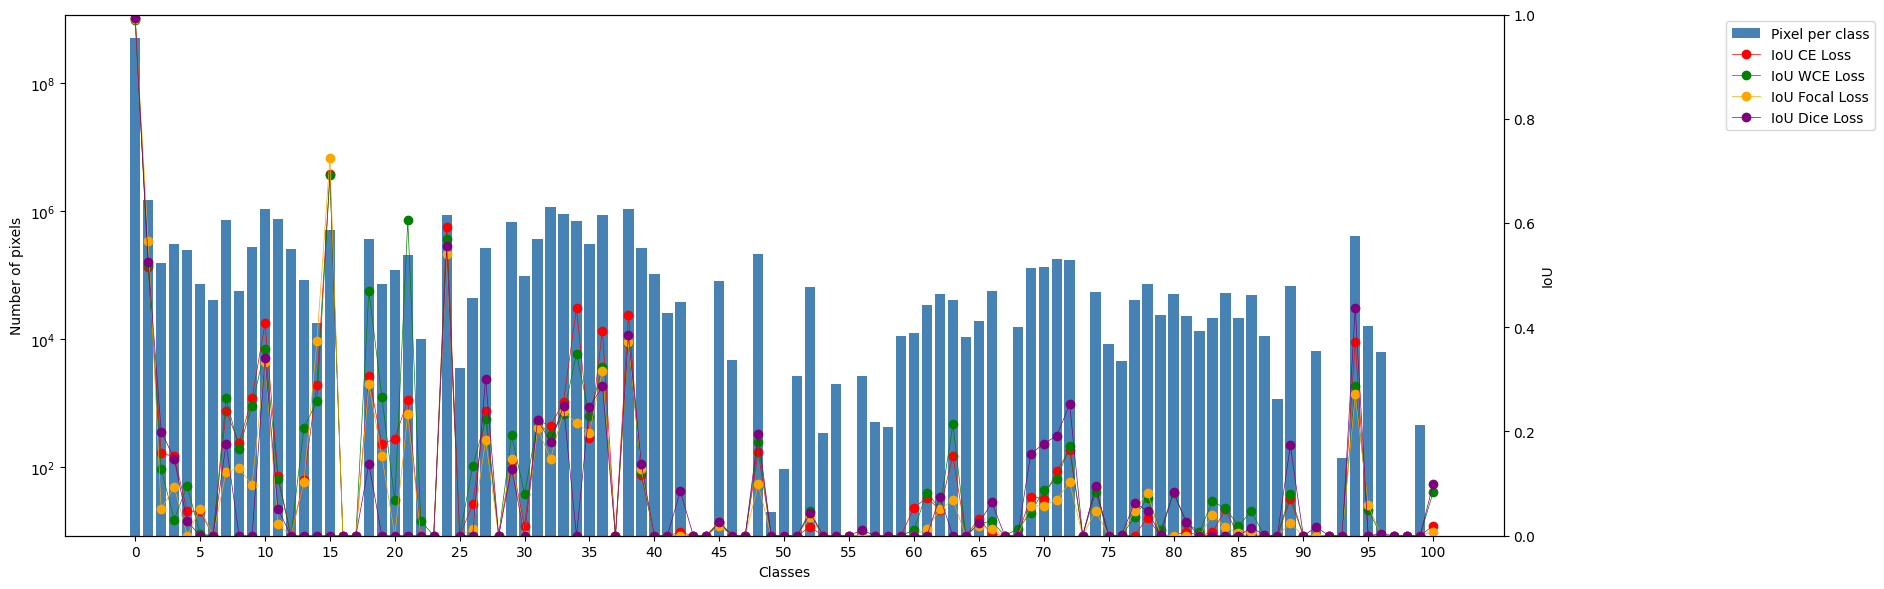

In [14]:
# GRAFICO IOU PER LE DIVERSE FUNZIONI DI PERDITA
classes = np.arange(num_classes)

# 4 array di iou
iou_CE = np.array([0.9936, 0.5148, 0.1579, 0.1521, 0.0471, 0.0468, 0, 0.2394, 0.1774, 0.2640, 0.4072, 0.1150, 0.0000, 
                   0.1076, 0.2901, 0.6932, 0, 0, 0.3060, 0.1751, 0.1864, 0.2599, 0.0000, 0, 0.5932, 0, 0.0601, 0.2397, 
                   0, 0.1427, 0.0181, 0.2217, 0.2105, 0.2575, 0.4363, 0.1883, 0.3935, 0, 0.4234, 0.1167, 0.0000, 0, 
                   0.0066, 0, 0, 0.0271, 0, 0, 0.1606, 0, 0, 0, 0.0169, 0, 0, 0, 0.0000, 0, 0, 0.0000, 0.0540, 0.0726, 
                   0.0501, 0.1535, 0.0000, 0.0325, 0.0032, 0, 0.0000, 0.0747, 0.0714, 0.1246, 0.1641, 0, 0.0910, 0, 
                   0.0000, 0.0004, 0.0349, 0.0000, 0.0002, 0.0079, 0.0000, 0.0065, 0.0506, 0.0001, 0.0021, 0.0000, 0, 
                   0.0702, 0, 0.0000, 0, 0, 0.3717, 0.0000, 0.0000, 0, 0, 0, 0.0193])

iou_WCE = np.array([0.9893, 0.5189, 0.1276, 0.0308, 0.0956, 0.0032, 0, 0.2633, 0.1673, 0.2493, 0.3578, 0.1085, 0.0000,
                    0.2070, 0.2584, 0.6919, 0, 0, 0.4704, 0.2668, 0.0680, 0.6048, 0.0289, 0, 0.5702, 0, 0.1330, 0.2233,
                    0, 0.1929, 0.0794, 0.2186, 0.1931, 0.2327, 0.3488, 0.2303, 0.3243, 0, 0.3689, 0.1215, 0.0000, 0, 
                    0.0000, 0, 0, 0.0222, 0, 0, 0.1790, 0, 0, 0, 0.0472, 0, 0, 0, 0.0000, 0, 0, 0.0000, 0.0111, 0.0829,
                    0.0515, 0.2138, 0.0000, 0.0233, 0.0278, 0, 0.0131, 0.0433, 0.0878, 0.1080, 0.1716, 0, 0.0836, 0, 
                    0.0000, 0.0356, 0.0725, 0.0101, 0.0829, 0.0242, 0.0076, 0.0659, 0.0527, 0.0193, 0.0468, 0.0000, 0, 
                    0.0797, 0, 0.0000, 0, 0, 0.2877, 0.0502, 0.0000, 0, 0, 0, 0.0834])

iou_FOCAL = np.array([0.9923, 0.5659, 0.0505, 0.0941, 0.0003, 0.0518, 0, 0.1228, 0.1295, 0.0975, 0.3333, 0.0218, 0.0000,
                      0.1035, 0.3743, 0.7248, 0, 0, 0.2909, 0.1528, 0.0000, 0.2342, 0.0000, 0, 0.5410, 0, 0.0127, 
                      0.1843, 0, 0.1472, 0.0014, 0.2062, 0.1475, 0.2388, 0.2165, 0.1978, 0.3169, 0, 0.3716, 0.1281, 
                      0.0000, 0, 0.0000, 0, 0, 0.0182, 0, 0, 0.0986, 0, 0, 0, 0.0361, 0, 0, 0, 0.0000, 0, 0, 0.0000, 
                      0.0000, 0.0135, 0.0508, 0.0681, 0.0000, 0.0196, 0.0134, 0, 0.0000, 0.0579, 0.0570, 0.0692, 0.1025,
                      0, 0.0477, 0, 0.0000, 0.0480, 0.0828, 0.0000, 0.0000, 0.0001, 0.0000, 0.0401, 0.0172, 0.0043, 
                      0.0075, 0.0000, 0, 0.0235, 0, 0.0000, 0, 0, 0.2714, 0.0588, 0.0000, 0, 0, 0, 0.0081])

iou_DICE = np.array([0.9924, 0.5254, 0.1998, 0.1481, 0.0276, 0.0000, 0, 0.1766, 0.0000, 0.0000, 0.3407, 0.0515, 0.0000,
                     0.0000, 0.0000, 0.0000, 0, 0, 0.1376, 0.0000, 0.0000, 0.0000, 0.0000, 0, 0.5551, 0, 0.0000, 0.3015,
                     0, 0.1288, 0.0000, 0.2225, 0.1799, 0.2489, 0.0000, 0.2476, 0.2864, 0, 0.3846, 0.1369, 0.0000, 0, 
                     0.0856, 0, 0, 0.0258, 0, 0, 0.1957, 0, 0, 0, 0.0432, 0, 0, 0, 0.0111, 0, 0, 0.0000, 0.0000, 0.0000,
                     0.0744, 0.0000, 0.0000, 0.0235, 0.0638, 0, 0.0000, 0.1572, 0.1763, 0.1919, 0.2519, 0, 0.0946, 0, 
                     0.0006, 0.0636, 0.0472, 0.0020, 0.0838, 0.0257, 0.0000, 0.0000, 0.0000, 0.0000, 0.0156, 0.0016, 0, 
                     0.1731, 0, 0.0165, 0, 0, 0.4360, 0.0000, 0.0038, 0, 0, 0, 0.0985])

fig, ax1 = plt.subplots(figsize=(19, 6))

# --- Barre pixel (asse Y sinistro) ---
ax1.bar(classes, class_counts, color='steelblue', label="Pixel per class")
ax1.set_yscale('log')
ax1.set_ylabel("Number of pixels")

# --- Linee recall (asse Y destro) ---
ax2 = ax1.twinx()
ax2.plot(classes, iou_CE, color='red', marker='o', linewidth=0.5, label="IoU CE Loss")
ax2.plot(classes, iou_WCE, color='green', marker='o', linewidth=0.5, label="IoU WCE Loss")
ax2.plot(classes, iou_FOCAL, color='orange', marker='o', linewidth=0.5, label="IoU Focal Loss")
ax2.plot(classes, iou_DICE, color='purple', marker='o', linewidth=0.5, label="IoU Dice Loss")
ax2.set_ylabel("IoU")
ax2.set_ylim(0, 1)

ax1.set_xlabel("Classes")
ax1.set_xticks(np.arange(0, num_classes, 5))

# --- Legenda combinata (barre + linee) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2,
           loc="upper left",             # posizione di riferimento
           bbox_to_anchor=(1.15, 1))    # sposta fuori a destra

plt.tight_layout()
plt.savefig("CaW_IoU_Losses.png", dpi=300)
plt.show()

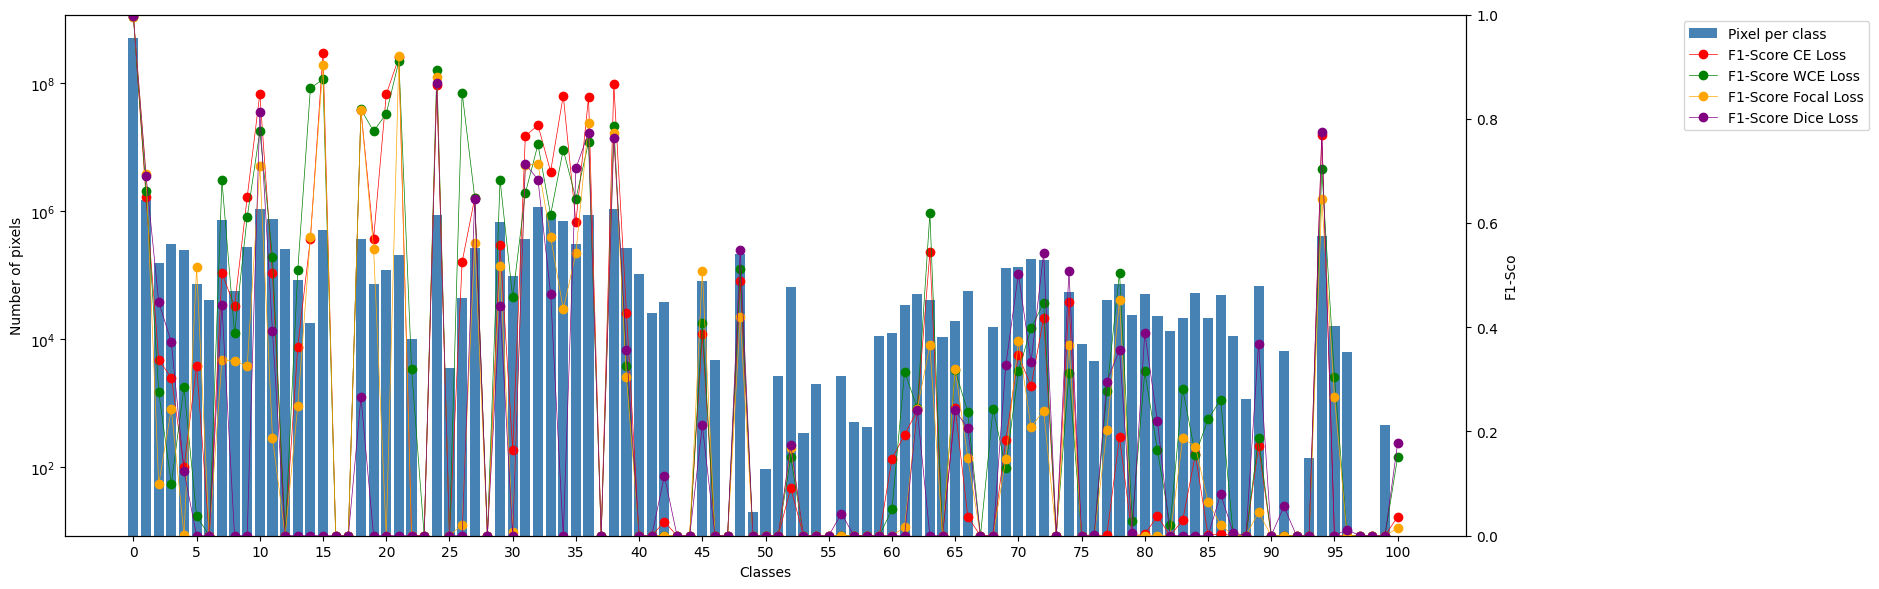

In [15]:
# GRAFICO F1 PER LE DIVERSE FUNZIONI DI PERDITA
classes = np.arange(num_classes)

# 4 array di f1
F1_CE = np.array([0.9968, 0.6493, 0.3371, 0.3034, 0.1309, 0.3260, 0, 0.5037, 0.4403, 0.6496, 0.8480, 0.5036, 0.0000, 
                  0.3630, 0.5699, 0.9265, 0, 0, 0.8160, 0.5698, 0.8470, 0.9176, 0.0000, 0, 0.8640, 0, 0.5251, 0.6482, 
                  0, 0.5571, 0.1648, 0.7667, 0.7878, 0.6986, 0.8445, 0.6014, 0.8409, 0, 0.8663, 0.4272, 0.0000, 0, 
                  0.0269, 0, 0, 0.3865, 0, 0, 0.4878, 0, 0, 0, 0.0917, 0, 0, 0, 0.0000, 0, 0, 0.0000, 0.1474, 0.1938, 
                  0.2403, 0.5436, 0.0000, 0.2455, 0.0362, 0, 0.0000, 0.1828, 0.3466, 0.2868, 0.4179, 0, 0.4491, 0, 
                  0.0000, 0.0012, 0.1893, 0.0000, 0.0025, 0.0382, 0.0000, 0.0298, 0.1559, 0.0016, 0.0035, 0.0000, 0, 
                  0.1712, 0, 0.0000, 0, 0, 0.7690, 0.0000, 0.0000, 0, 0, 0, 0.0366])

F1_WCE = np.array([0.9946, 0.6619, 0.2767, 0.0991, 0.2850, 0.0379, 0, 0.6819, 0.3888, 0.6110, 0.7757, 0.5346, 0.0000, 
                   0.5089, 0.8586, 0.8757, 0, 0, 0.8179, 0.7761, 0.8097, 0.9108, 0.3208, 0, 0.8938, 0, 0.8501, 0.6485, 
                   0, 0.6830, 0.4571, 0.6572, 0.7506, 0.6159, 0.7407, 0.6464, 0.7546, 0, 0.7870, 0.3249, 0.0000, 0, 
                   0.0000, 0, 0, 0.4073, 0, 0, 0.5124, 0, 0, 0, 0.1504, 0, 0, 0, 0.0000, 0, 0, 0.0000, 0.0504, 0.3147, 
                   0.2451, 0.6185, 0.0000, 0.3174, 0.2372, 0, 0.2440, 0.1304, 0.3158, 0.3977, 0.4472, 0, 0.3117, 0, 
                   0.0000, 0.2777, 0.5050, 0.0292, 0.3151, 0.1641, 0.0199, 0.2817, 0.1552, 0.2233, 0.2612, 0.0000, 0, 
                   0.1876, 0, 0.0000, 0, 0, 0.7035, 0.3053, 0.0000, 0, 0, 0, 0.1511])

F1_FOCAL = np.array([0.9961, 0.6946, 0.0983, 0.2440, 0.0013, 0.5148, 0, 0.3375, 0.3356, 0.3249, 0.7092, 0.1876, 0.0000,
                     0.2490, 0.5732, 0.9037, 0, 0, 0.8160, 0.5500, 0.0000, 0.9202, 0.0000, 0, 0.8801, 0, 0.0215, 0.5625,
                     0, 0.5171, 0.0074, 0.7114, 0.7132, 0.5734, 0.4346, 0.5419, 0.7927, 0, 0.7726, 0.3040, 0.0000, 0, 
                     0.0000, 0, 0, 0.5079, 0, 0, 0.4191, 0, 0, 0, 0.1688, 0, 0, 0, 0.0000, 0, 0, 0.0000, 0.0000, 0.0163,
                     0.2430, 0.3655, 0.0000, 0.3200, 0.1493, 0, 0.0000, 0.1465, 0.3736, 0.2082, 0.2400, 0, 0.3659, 0, 
                     0.0000, 0.2029, 0.4519, 0.0000, 0.0002, 0.0004, 0.0000, 0.1874, 0.1711, 0.0646, 0.0210, 0.0000, 0, 
                     0.0453, 0, 0.0000, 0, 0, 0.6466, 0.2661, 0.0000, 0, 0, 0, 0.0145])

F1_DICE = np.array([0.9962, 0.6909, 0.4488, 0.3709, 0.1241, 0.0000, 0, 0.4434, 0.0000, 0.0000, 0.8124, 0.3923, 0.0000, 
                    0.0000, 0.0000, 0.0000, 0, 0, 0.2664, 0.0000, 0.0000, 0.0000, 0.0000, 0, 0.8682, 0, 0.0000, 0.6467,
                    0, 0.4402, 0.0000, 0.7133, 0.6834, 0.4645, 0.0000, 0.7050, 0.7731, 0, 0.7638, 0.3569, 0.0000, 0, 
                    0.1150, 0, 0, 0.2116, 0, 0, 0.5489, 0, 0, 0, 0.1748, 0, 0, 0, 0.0425, 0, 0, 0.0000, 0.0000, 0.0000,
                    0.2415, 0.0000, 0.0000, 0.2406, 0.2058, 0, 0.0000, 0.3267, 0.5025, 0.3335, 0.5424, 0, 0.5079, 0, 
                    0.0018, 0.2955, 0.3572, 0.0046, 0.3894, 0.2195, 0.0000, 0.0000, 0.0000, 0.0000, 0.0795, 0.0055, 0,
                    0.3687, 0, 0.0563, 0, 0, 0.7741, 0.0000, 0.0117, 0, 0, 0, 0.1782])

fig, ax1 = plt.subplots(figsize=(19, 6))

# --- Barre pixel (asse Y sinistro) ---
ax1.bar(classes, class_counts, color='steelblue', label="Pixel per class")
ax1.set_yscale('log')
ax1.set_ylabel("Number of pixels")

# --- Linee recall (asse Y destro) ---
ax2 = ax1.twinx()
ax2.plot(classes, F1_CE, color='red', marker='o', linewidth=0.5, label="F1-Score CE Loss")
ax2.plot(classes, F1_WCE, color='green', marker='o', linewidth=0.5, label="F1-Score WCE Loss")
ax2.plot(classes, F1_FOCAL, color='orange', marker='o', linewidth=0.5, label="F1-Score Focal Loss")
ax2.plot(classes, F1_DICE, color='purple', marker='o', linewidth=0.5, label="F1-Score Dice Loss")
ax2.set_ylabel("F1-Sco")
ax2.set_ylim(0, 1)

ax1.set_xlabel("Classes")
ax1.set_xticks(np.arange(0, num_classes, 5))

# --- Legenda combinata (barre + linee) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2,
           loc="upper left",             # posizione di riferimento
           bbox_to_anchor=(1.15, 1))    # sposta fuori a destra

plt.tight_layout()
plt.savefig("CaW_F1_Losses.png", dpi=300)
plt.show()

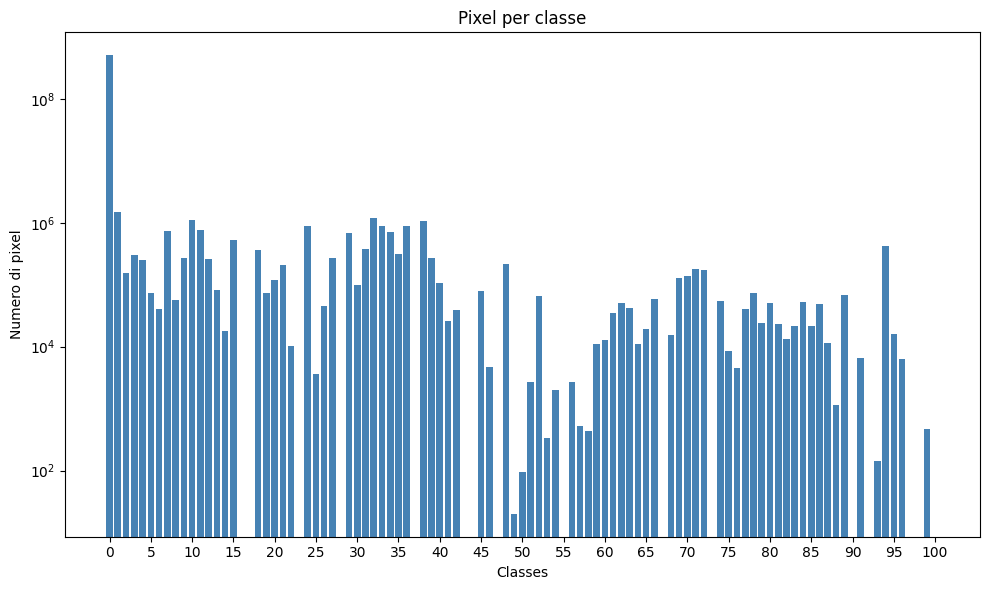

In [13]:
classes = np.arange(num_classes)   # [0, 1, 2, ...]
counts  = class_counts             # array con i pixel per classe

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='steelblue')

plt.yscale('log')  # scala logaritmica sull'asse Y
plt.ylabel("Numero di pixel")
plt.xlabel("Classes")
plt.title("Pixel per classe")

# Etichette X = indici numerici ogni 5 classi
tick_positions = np.arange(0, num_classes, 5)
plt.xticks(tick_positions, [str(i) for i in tick_positions])

plt.tight_layout()
plt.savefig("pixel_per_classe_log_vertical.png", dpi=300)
plt.show()


In [7]:
"""
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean', ignore_index=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Tensor di pesi per classe, oppure None
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, input, target):
        """
        input: (N, C, H, W) — logit grezzi
        target: (N, H, W) — etichette classe
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)

        # Se alpha è definita, applichiamo peso per classe
        if self.alpha is not None:
            at = self.alpha.to(input.device)[target]  # shape (N, H, W)
        else:
            at = 1.0

        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, target.unsqueeze(1)).squeeze(1)

        loss = -at * (1 - pt) ** self.gamma * logpt

        if self.ignore_index is not None:
            mask = target != self.ignore_index
            loss = loss[mask]

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss
"""

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, inputs, targets):
        """
        inputs: logits (B, C, H, W) -> passare tramite softmax
        targets: (B, H, W) con classi [0..C-1]
        """
        inputs = torch.softmax(inputs, dim=1)

        num_classes = inputs.shape[1]
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)

        intersection = torch.sum(inputs * targets_one_hot, dims)
        cardinality = torch.sum(inputs + targets_one_hot, dims)

        dice_score = (2. * intersection + self.epsilon) / (cardinality + self.epsilon)
        dice_loss = 1 - dice_score

        return dice_loss.mean()

In [6]:
"""Imposta il dispositivo di calcolo sulla GPU e sposta il modello sul dispositivo. 
Utilizza la Cross Entropy Loss come funzione di perdita e Adam come ottimizzatore con leraning rate 0.001"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
"loss_fn = nn.CrossEntropyLoss()"
"loss_fn = nn.CrossEntropyLoss(weight = weights_tensor)"
"loss_fn = FocalLoss(gamma=2.0)"
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
"""Calcolo dell'IoU:
- intersection: numero di pixel correttamente classificati per quella classe
- union: tutti i pixel predetti o etichettati come quella classe
Restituisce la media delle IoU tra tutte le classi, ignorando i nan (classe non presente nè nella predizione
nè nella label)"""
def compute_iou(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1).view(-1)
    labels = labels.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return torch.tensor(ious)

In [10]:
"""Addestramento del modello per una singola epoca"""
def train_one_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

"""Valuta il modello su un dataloader di validazione (senza l'aggiornamento dei pesi)"""
def validate(model, dataloader, loss_fn, num_classes=101):
    
    f1_metric = F1Score(num_classes=num_classes, average=None, task='multiclass').to(device)
    precision_metric = Precision(num_classes=num_classes, average=None, task='multiclass').to(device)
    recall_metric = Recall(num_classes=num_classes, average=None, task='multiclass').to(device)

    model.eval()
    val_loss = 0
    iou_per_class_list = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            f1_metric.update(preds, masks)
            precision_metric.update(preds, masks)
            recall_metric.update(preds, masks)

            ious = compute_iou(outputs, masks, num_classes)
            iou_per_class_list.append(ious)

            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    mean_ious_per_class = torch.stack(iou_per_class_list).nanmean(dim=0)  # [num_classes]

    # Metriche per classe
    f1_per_class = f1_metric.compute()
    precision_per_class = precision_metric.compute()
    recall_per_class = recall_metric.compute()

    # Metriche globali
    global_iou = torch.nanmean(mean_ious_per_class).item()
    global_f1 = torch.nanmean(f1_per_class).item()
    global_precision = torch.nanmean(precision_per_class).item()
    global_recall = torch.nanmean(recall_per_class).item()

    return (val_loss / len(dataloader),
            global_iou, global_f1, global_precision, global_recall,
            mean_ious_per_class, f1_per_class, precision_per_class, recall_per_class)

In [11]:
"""Addestra il modello per 50 epoche salvando il modello migliore. L'addestramento si interrompe se per 10 epoche
non avviene nessun miglioramento."""
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer)

    # Validation
    (val_loss, global_iou, global_f1, global_precision, global_recall,
     iou_per_class, f1_per_class, precision_per_class, recall_per_class) = validate(model, val_loader, loss_fn)

    # Stampa metriche globali e per classe
    print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Global -> IoU: {global_iou:.4f} | F1: {global_f1:.4f} | Precision: {global_precision:.4f} | Recall: {global_recall:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "ENB0+UNet_models/CropAndWeed_seg_standard_DiceLoss.pth")
        print("✅ Model saved.")
    else:
        print("No improvement.")

    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_iou": global_iou,
        "val_f1": global_f1,
        "val_precision": global_precision,
        "val_recall": global_recall,

        **{f"ClassMetrics/iou_class_{i}": v for i, v in enumerate(iou_per_class.tolist())},
        **{f"ClassMetrics/f1_class_{i}": v for i, v in enumerate(f1_per_class.tolist())},
        **{f"ClassMetrics/precision_class_{i}": v for i, v in enumerate(precision_per_class.tolist())},
        **{f"ClassMetrics/recall_class_{i}": v for i, v in enumerate(recall_per_class.tolist())},
    })

wandb.finish()


Epoch 1/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.24it/s]



Train Loss: 0.9848 | Val Loss: 0.9900
Global -> IoU: 0.0129 | F1: 0.0100 | Precision: 0.0253 | Recall: 0.0100
✅ Model saved.

Epoch 2/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9651 | Val Loss: 0.9769
Global -> IoU: 0.0252 | F1: 0.0348 | Precision: 0.0625 | Recall: 0.0312
✅ Model saved.

Epoch 3/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9434 | Val Loss: 0.9538
Global -> IoU: 0.0471 | F1: 0.0778 | Precision: 0.0890 | Recall: 0.0884
✅ Model saved.

Epoch 5/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9381 | Val Loss: 0.9471
Global -> IoU: 0.0533 | F1: 0.0896 | Precision: 0.0934 | Recall: 0.1036
✅ Model saved.

Epoch 6/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9342 | Val Loss: 0.9359
Global -> IoU: 0.0667 | F1: 0.1114 | Precision: 0.1169 | Recall: 0.1233
✅ Model saved.

Epoch 7/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9299 | Val Loss: 0.9353
Global -> IoU: 0.0668 | F1: 0.1179 | Precision: 0.1278 | Recall: 0.1318
✅ Model saved.

Epoch 8/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.24it/s]



Train Loss: 0.9227 | Val Loss: 0.9310
Global -> IoU: 0.0707 | F1: 0.1222 | Precision: 0.1288 | Recall: 0.1425
✅ Model saved.

Epoch 9/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9196 | Val Loss: 0.9418
Global -> IoU: 0.0604 | F1: 0.1037 | Precision: 0.1293 | Recall: 0.1146
No improvement.

Epoch 10/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9194 | Val Loss: 0.9276
Global -> IoU: 0.0740 | F1: 0.1315 | Precision: 0.1430 | Recall: 0.1460
✅ Model saved.

Epoch 11/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9122 | Val Loss: 0.9315
Global -> IoU: 0.0699 | F1: 0.1292 | Precision: 0.1548 | Recall: 0.1326
No improvement.

Epoch 12/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.24it/s]



Train Loss: 0.9100 | Val Loss: 0.9239
Global -> IoU: 0.0776 | F1: 0.1395 | Precision: 0.1480 | Recall: 0.1573
✅ Model saved.

Epoch 13/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.9059 | Val Loss: 0.9193
Global -> IoU: 0.0824 | F1: 0.1471 | Precision: 0.1542 | Recall: 0.1612
✅ Model saved.

Epoch 14/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.5945 | Val Loss: 0.5245
Global -> IoU: 0.0855 | F1: 0.1480 | Precision: 0.1665 | Recall: 0.1560
✅ Model saved.

Epoch 15/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.5074 | Val Loss: 0.5177
Global -> IoU: 0.0933 | F1: 0.1661 | Precision: 0.1660 | Recall: 0.1866
✅ Model saved.

Epoch 16/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.5039 | Val Loss: 0.5158
Global -> IoU: 0.0946 | F1: 0.1611 | Precision: 0.1823 | Recall: 0.1709
✅ Model saved.

Epoch 17/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.5009 | Val Loss: 0.5176
Global -> IoU: 0.0894 | F1: 0.1631 | Precision: 0.1796 | Recall: 0.1763
No improvement.

Epoch 18/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4995 | Val Loss: 0.5155
Global -> IoU: 0.0949 | F1: 0.1662 | Precision: 0.1746 | Recall: 0.1836
✅ Model saved.

Epoch 19/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.24it/s]



Train Loss: 0.4871 | Val Loss: 0.4951
Global -> IoU: 0.1027 | F1: 0.1798 | Precision: 0.1892 | Recall: 0.1885
✅ Model saved.

Epoch 20/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4790 | Val Loss: 0.5040
Global -> IoU: 0.0930 | F1: 0.1628 | Precision: 0.1872 | Recall: 0.1648
No improvement.

Epoch 21/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4766 | Val Loss: 0.4984
Global -> IoU: 0.0988 | F1: 0.1775 | Precision: 0.1880 | Recall: 0.1927
No improvement.

Epoch 22/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4781 | Val Loss: 0.5062
Global -> IoU: 0.0863 | F1: 0.1577 | Precision: 0.1700 | Recall: 0.1725
No improvement.

Epoch 23/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4794 | Val Loss: 0.4959
Global -> IoU: 0.0926 | F1: 0.1702 | Precision: 0.1759 | Recall: 0.1925
No improvement.

Epoch 24/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4740 | Val Loss: 0.4836
Global -> IoU: 0.0992 | F1: 0.1816 | Precision: 0.1887 | Recall: 0.2017
✅ Model saved.

Epoch 25/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.24it/s]



Train Loss: 0.4626 | Val Loss: 0.4939
Global -> IoU: 0.0893 | F1: 0.1695 | Precision: 0.1781 | Recall: 0.1868
No improvement.

Epoch 26/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4612 | Val Loss: 0.4800
Global -> IoU: 0.1044 | F1: 0.1811 | Precision: 0.1930 | Recall: 0.1975
✅ Model saved.

Epoch 27/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4623 | Val Loss: 0.4894
Global -> IoU: 0.0882 | F1: 0.1652 | Precision: 0.1721 | Recall: 0.1795
No improvement.

Epoch 28/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4580 | Val Loss: 0.4795
Global -> IoU: 0.0952 | F1: 0.1723 | Precision: 0.1789 | Recall: 0.1970
✅ Model saved.

Epoch 29/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4520 | Val Loss: 0.4856
Global -> IoU: 0.0897 | F1: 0.1704 | Precision: 0.1836 | Recall: 0.1919
No improvement.

Epoch 30/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4530 | Val Loss: 0.4744
Global -> IoU: 0.1017 | F1: 0.1844 | Precision: 0.1902 | Recall: 0.2010
✅ Model saved.

Epoch 31/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4488 | Val Loss: 0.4729
Global -> IoU: 0.1036 | F1: 0.1822 | Precision: 0.1832 | Recall: 0.2046
✅ Model saved.

Epoch 32/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4478 | Val Loss: 0.4769
Global -> IoU: 0.0974 | F1: 0.1779 | Precision: 0.1863 | Recall: 0.2005
No improvement.

Epoch 33/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4473 | Val Loss: 0.4725
Global -> IoU: 0.1043 | F1: 0.1903 | Precision: 0.2030 | Recall: 0.2021
✅ Model saved.

Epoch 34/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4456 | Val Loss: 0.4645
Global -> IoU: 0.1015 | F1: 0.1843 | Precision: 0.1859 | Recall: 0.2038
✅ Model saved.

Epoch 35/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4276 | Val Loss: 0.4383
Global -> IoU: 0.1031 | F1: 0.1841 | Precision: 0.1935 | Recall: 0.1952
✅ Model saved.

Epoch 36/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4172 | Val Loss: 0.4391
Global -> IoU: 0.1038 | F1: 0.1852 | Precision: 0.1905 | Recall: 0.2023
No improvement.

Epoch 37/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4167 | Val Loss: 0.4390
Global -> IoU: 0.0934 | F1: 0.1682 | Precision: 0.1769 | Recall: 0.1870
No improvement.

Epoch 38/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4064 | Val Loss: 0.4320
Global -> IoU: 0.1008 | F1: 0.1793 | Precision: 0.1793 | Recall: 0.2000
✅ Model saved.

Epoch 39/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4095 | Val Loss: 0.4290
Global -> IoU: 0.1052 | F1: 0.1858 | Precision: 0.1986 | Recall: 0.1989
✅ Model saved.

Epoch 40/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4052 | Val Loss: 0.4296
Global -> IoU: 0.1065 | F1: 0.1835 | Precision: 0.1996 | Recall: 0.1935
No improvement.

Epoch 41/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4058 | Val Loss: 0.4321
Global -> IoU: 0.1022 | F1: 0.1805 | Precision: 0.1817 | Recall: 0.2092
No improvement.

Epoch 42/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4031 | Val Loss: 0.4475
Global -> IoU: 0.0857 | F1: 0.1552 | Precision: 0.1792 | Recall: 0.1651
No improvement.

Epoch 43/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4029 | Val Loss: 0.4302
Global -> IoU: 0.1061 | F1: 0.1810 | Precision: 0.1875 | Recall: 0.2004
No improvement.

Epoch 44/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4029 | Val Loss: 0.4251
Global -> IoU: 0.1101 | F1: 0.1918 | Precision: 0.1961 | Recall: 0.2090
✅ Model saved.

Epoch 45/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.3991 | Val Loss: 0.4258
Global -> IoU: 0.1016 | F1: 0.1757 | Precision: 0.1911 | Recall: 0.1871
No improvement.

Epoch 46/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.4015 | Val Loss: 0.4214
Global -> IoU: 0.1049 | F1: 0.1841 | Precision: 0.1909 | Recall: 0.1970
✅ Model saved.

Epoch 47/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.3921 | Val Loss: 0.4262
Global -> IoU: 0.0995 | F1: 0.1712 | Precision: 0.1822 | Recall: 0.1868
No improvement.

Epoch 48/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.3952 | Val Loss: 0.4199
Global -> IoU: 0.1007 | F1: 0.1752 | Precision: 0.1710 | Recall: 0.1983
✅ Model saved.

Epoch 49/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]



Train Loss: 0.3890 | Val Loss: 0.4219
Global -> IoU: 0.1003 | F1: 0.1753 | Precision: 0.1804 | Recall: 0.1934
No improvement.

Epoch 50/50


Validation: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s]


Train Loss: 0.3892 | Val Loss: 0.4293
Global -> IoU: 0.0863 | F1: 0.1550 | Precision: 0.1774 | Recall: 0.1649
No improvement.


ClassMetrics/f1_class_0,▁▃█▇███████████████████████████████████▇
ClassMetrics/f1_class_1,▁▄▇▃▆▆▇▆▇▇▇▆▇▇▇▇▆▆▇▄▇▇▆▂█▇▇▇▇▇███▇▇█▇██▆
ClassMetrics/f1_class_10,▁▂▅▇▆▇▆▇▇▇▇▇▇▆▇▆▇▇██▅▇▇███████████▇████▇
ClassMetrics/f1_class_100,▁▂▅▄▆▆▆▇▆▆▆▇▆▇▇█▇▆▇▇▇▇▇▇█████▇█▇██▇██▇██
ClassMetrics/f1_class_11,▁▁▂▄▃▆▄▄▅▅▃▆▂▃▆▄▆▄▄▄▅▆▆▅▅▄▅▆▇▆▆▆▆▆▄▆▇██▄
ClassMetrics/f1_class_12,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ClassMetrics/f1_class_13,▁▁▁▂▂▄▄▃▅▅▄▄▅▅▆▇▅▆▇▇▆▇▇▆▇█▆█▁▁▁▁▁▁▁▁▁▁▁▁
ClassMetrics/f1_class_14,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ClassMetrics/f1_class_15,▁▄▇▅▇▆█▆▇▇▇▇██▇██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ClassMetrics/f1_class_16,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ClassMetrics/f1_class_17,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [11]:
print("Immagini del set di test:")
for filename in test_ids:
    print(filename)

Immagini del set di test:
vwg-0380-0003.jpg
vwg-0546-0030.jpg
vwg-1335-0003.jpg
vwg-0042-0021.jpg
vwg-1224-0008.jpg
ave-0230-0021.jpg
vwg-0022-0022.jpg
ave-0339-0003.jpg
ave-0210-0013.jpg
ave-0265-0013.jpg
ave-0519-0014.jpg
vwg-0022-0005.jpg
ave-0291-0013.jpg
vwg-0706-0020.jpg
vwg-0640-0015.jpg
ave-0297-0009.jpg
ave-0295-0012.jpg
ave-0544-0009.jpg
vwg-0152-0015.jpg
ave-0540-0017.jpg
ave-0256-0014.jpg
ave-0501-0012.jpg
vwg-1238-0002.jpg
ave-0540-0004.jpg
vwg-0416-0042.jpg
ave-0181-0002.jpg
vwg-0022-0014.jpg
ave-0357-0007.jpg
vwg-0423-0001.jpg
vwg-0405-0029.jpg
vwg-0229-0014.jpg
vwg-1273-0002.jpg
vwg-1253-0018.jpg
ave-0507-0016.jpg
vwg-1265-0011.jpg
vwg-1328-0003.jpg
vwg-0783-0013.jpg
ave-0593-0018.jpg
vwg-1275-0012.jpg
ave-0265-0009.jpg
ave-0153-0007.jpg
ave-0231-0007.jpg
vwg-1285-0015.jpg
vwg-0279-0001.jpg
vwg-0644-0005.jpg
ave-0326-0013.jpg
vwg-0861-0003.jpg
ave-0063-0014.jpg
vwg-0038-0000.jpg
vwg-1279-0008.jpg
vwg-0445-0021.jpg
vwg-0802-0002.jpg
ave-0358-0026.jpg
vwg-1167-0009.jpg
vw

In [8]:
class_colors = [
    (0, 0, 0), (255, 0, 0), (234, 0, 0), (212, 0, 0), (191, 0, 0), (170, 0, 0), (149, 0, 0),
    (255, 85, 0), (234, 78, 0), (212, 71, 0), (191, 64, 0), (170, 57, 0), (149, 50, 0),
    (255, 170, 0), (255, 255, 0), (170, 255, 0), (85, 255, 0), (0, 255, 0), (0, 255, 85),
    (0, 255, 170), (0, 255, 255), (0, 170, 255), (0, 85, 255), (0, 0, 255), (85, 0, 255),
    (170, 0, 255), (255, 0, 255), (255, 0, 170), (255, 0, 85), (255, 188, 178), (255, 207, 178),
    (255, 226, 178), (255, 245, 178), (245, 255, 178), (226, 255, 178), (207, 255, 178),
    (188, 255, 178), (178, 255, 188), (178, 255, 207), (178, 255, 226), (178, 255, 245),
    (178, 245, 255), (178, 226, 255), (178, 207, 255), (178, 188, 255), (188, 178, 255),
    (207, 178, 255), (226, 178, 255), (245, 178, 255), (255, 178, 245), (255, 178, 226),
    (255, 178, 207), (255, 178, 188), (255, 194, 178), (255, 213, 178), (255, 219, 178),
    (255, 232, 178), (255, 238, 178), (255, 251, 178), (255, 212, 0), (239, 255, 178),
    (233, 255, 178), (220, 255, 178), (214, 255, 178), (201, 255, 178), (195, 255, 178),
    (182, 255, 178), (178, 255, 194), (178, 255, 200), (178, 255, 213), (178, 255, 220),
    (178, 255, 232), (178, 255, 238), (178, 255, 251), (178, 239, 255), (178, 233, 255),
    (178, 220, 255), (178, 214, 255), (178, 201, 255), (178, 195, 255), (178, 182, 255),
    (194, 178, 255), (200, 178, 255), (213, 178, 255), (219, 178, 255), (232, 178, 255),
    (238, 178, 255), (251, 178, 255), (255, 178, 239), (255, 178, 233), (255, 178, 220),
    (255, 178, 214), (212, 255, 0), (127, 255, 0), (42, 255, 0), (244, 255, 0), (159, 255, 0),
    (74, 255, 0), (10, 255, 0), (202, 255, 0), (128, 128, 128)
]

In [9]:
""" Converte una maschera di classi in un'immagine RGB creando un'immagine vuota per poi colorare 
i pixel della maschera con il colore corrispondente """
def decode_segmap(segmentation_mask):
    h, w = segmentation_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(class_colors):
        color_mask[segmentation_mask == class_idx] = color
    return color_mask

In [27]:
""" Visualizza immagine, maschera originale e predetta per un dato filename. """
def show_prediction_for_image(filename, model, dataset):
    model.eval()

    try:
        idx = dataset.image_ids.index(filename)
    except ValueError:
        print(f"❌ File '{filename}' non trovato nel set di testing.")
        return

    image, mask = dataset[idx]

    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    mask_np = mask.cpu().numpy()
    mask_rgb = decode_segmap(mask_np)

    plt.imshow(mask_rgb)
    plt.axis("off")
    plt.show()

    plt.imsave("CaW_mask.png", mask_rgb)

/tmp/ipykernel_2885968/287863280.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ENB0+UNet_models/CropAndWeed_seg_standard_CrossEntropy

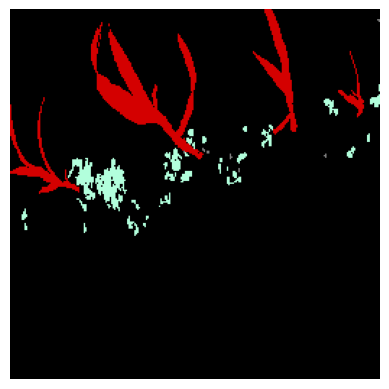

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("ENB0+UNet_models/CropAndWeed_seg_standard_CrossEntropyLoss.pth", map_location=device))
model.to(device)

test_dataset = CropAndWeedDataset(test_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=val_transform)

show_prediction_for_image("vwg-1323-0007.jpg", model, test_dataset)

# vwg-0416-0042.jpg   vwg-0380-0003.jpg   ave-0259-0020.jpg   ave-0540-0004.jpg   ave-0519-0009.jpg   vwg-0010-0006.jpg

In [31]:
""" Visualizza immagine originale e le predizioni dei tre modelli richiesti. """
def show_multiple_predictions(filename, models_paths, dataset):
    try:
        idx = dataset.image_ids.index(filename)
    except ValueError:
        print(f"❌ File '{filename}' non trovato nel set di testing.")
        return

    image, mask = dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)

    preds_rgb = []
    for model_path in models_paths:
        # Carica modello
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad():
            output = model(image_tensor)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        preds_rgb.append(decode_segmap(pred))

    img_np = image.cpu().permute(1, 2, 0).numpy()

    # # Visualizza i tre risultati
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 2)
    plt.imshow(preds_rgb[0])
    #plt.title("WCE Predicted mask")
    plt.axis("off")

    #plt.subplot(1, 4, 3)
    #plt.imshow(preds_rgb[1])
    #plt.title("Dice Predicted mask")
    #plt.axis("off")

    #plt.subplot(1, 4, 4)
    #plt.imshow(preds_rgb[2])
    #plt.title("Focal Predicted mask")
    #plt.axis("off")

    plt.tight_layout()
    plt.savefig("CaW_prediction_WCE.png", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_2885968/641852643.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


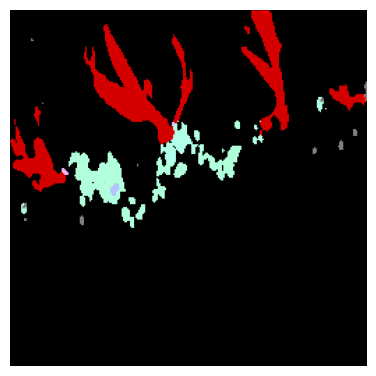

In [32]:
models_paths = [
    "ENB0+UNet_models/CropAndWeed_seg_weighted_CrossEntropyLoss.pth",
    "ENB0+UNet_models/CropAndWeed_seg_standard_DiceLoss.pth",
    "ENB0+UNet_models/CropAndWeed_seg_standard_FocalLoss.pth"
]

show_multiple_predictions("vwg-1323-0007.jpg", models_paths, test_dataset)